<a href="https://colab.research.google.com/github/Pavan-pk/deep_nn/blob/master/denoising_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

W0822 06:32:45.402741 140291006424960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 06:32:45.404877 140291006424960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_name (InputLayer)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decode

W0822 06:32:45.834745 140291006424960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_name (InputLayer)    (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108737    
Total params: 177,745
Trainable params: 177,745
Non-trainable params: 0
_________________________________________________________________


W0822 06:32:46.065970 140291006424960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0822 06:32:46.292140 140291006424960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 102s 2ms/step - loss: 0.0378 - val_loss: 0.0214
Epoch 2/20
60000/60000 [==============================] - 102s 2ms/step - loss: 0.0201 - val_loss: 0.0187
Epoch 3/20
60000/60000 [==============================] - 103s 2ms/step - loss: 0.0183 - val_loss: 0.0175
Epoch 4/20
60000/60000 [==============================] - 103s 2ms/step - loss: 0.0174 - val_loss: 0.0171
Epoch 5/20
60000/60000 [==============================] - 103s 2ms/step - loss: 0.0168 - val_loss: 0.0166
Epoch 6/20
60000/60000 [==============================] - 103s 2ms/step - loss: 0.0164 - val_loss: 0.0167
Epoch 7/20
60000/60000 [==============================] - 102s 2ms/step - loss: 0.0161 - val_loss: 0.0163
Epoch 8/20
60000/60000 [==============================] - 103s 2ms/step - loss: 0.0159 - val_loss: 0.0161
Epoch 9/20
60000/60000 [==============================] - 104s 2ms/step - loss: 0.0157 - val_loss: 0.0

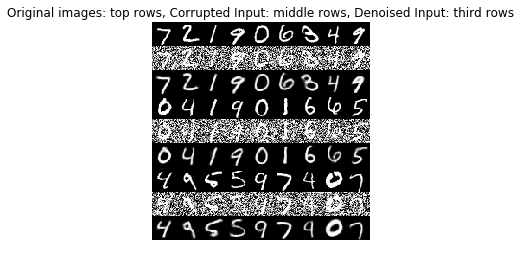

In [4]:
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, Input
from keras.utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.datasets import mnist


np.random.seed(1337)

(x_train, _), (x_test, _) = mnist.load_data()

image_size = x_train.shape[1]

x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

x_train = x_train.astype('float')/255.0
x_test = x_test.astype('float')/255.0

noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
filter_layers = [32, 64]
latent_dim = 16

inputs = Input(shape=input_shape, name='encoder_name')
x = inputs

for i in filter_layers:
    x = Conv2D(filters=i,
               kernel_size=kernel_size,
               strides=2,
               padding='same',
               activation='relu')(x)

shape = K.int_shape(x)

x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

encoder = Model(inputs, latent, name='encoder')
encoder.summary()

latent_inputs = Input(shape=(latent_dim, ), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in filter_layers[::-1]:
    x = Conv2DTranspose(filters=i,
                        kernel_size=kernel_size,
                        strides=2,
                        padding='same',
                        activation='relu')(x)
outputs = Conv2DTranspose(filters=1,
                    kernel_size=1,
                    padding='same',
                    activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=20,
                batch_size=32)

x_decoded = autoencoder.predict(x_test_noisy)
# 3 sets of images with 9 MNIST digits
# 1st rows - original images
# 2nd rows - images corrupted by noise
# 3rd rows - denoised images
rows, cols = 3, 9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
'Corrupted Input: middle rows, '
'Denoised Input: third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()


